# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.8' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("./")
# save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test7")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[CpuDevice(id=0)]


/local/home/hs276503/miniforge3/envs/testenv2/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


dphppce115.extra.cea.fr


In [2]:
from scipy.spatial.transform import Rotation

def radius_mesh(box_center, box_rot:Rotation, box_shape, mesh_shape):
    """
    Return physical distances of the mesh cells.
    """
    # Only Nx*Ny*Nz memory instead of naive Nx*Ny*Nz*3 obtained from mesh of positions 
    rx = np.arange(mesh_shape[0]).reshape([-1, 1, 1])
    ry = np.arange(mesh_shape[1]).reshape([1, -1, 1])
    rz = np.arange(mesh_shape[2]).reshape([1, 1, -1])
    rvec = rx, ry, rz

    box_center = box_rot.apply(box_center, inverse=True)
    # Use that ||Rx + c|| = ||x + R^T c|| to avoid computing Rx
    rvec = [r * b / m - b / 2 + c for r, m, b, c in zip(rvec, mesh_shape, box_shape, box_center)]
    rmesh = sum(ri**2 for ri in rvec)**.5
    return rmesh


def distr_radial(mesh, rmesh, redges:int|float|list, aggr_fn=None):
    assert np.shape(mesh) == np.shape(rmesh), "value mesh and radius mesh must have same shape."

    if isinstance(redges, (int, float)):
        rmin, rmax = rmesh.min(), rmesh.max()
        if isinstance(redges, int):
            dr = (rmax - rmin) / redges # final number of bins will be kedges-1
            redges = np.linspace(rmin, rmax, redges, endpoint=False)
        elif isinstance(redges, float):
            dr = redges
            redges = np.arange(rmin, rmax, dr)
        redges += dr/2 # from rmin+dr/2 to rmax-dr/2

    dig = np.digitize(rmesh.reshape(-1), redges)
    rcount = np.bincount(dig)
    rcount = rcount[1:-1]

    ravg = np.bincount(dig, weights=rmesh.reshape(-1))
    ravg = ravg[1:-1] / rcount

    if aggr_fn is None: # aggregate by averaging 
        naggr = np.bincount(dig, weights=mesh.reshape(-1))
        naggr = naggr[1:-1] / rcount
    else:
        naggr = []
        for low, high in zip(redges[:-1], redges[1:]):
            rmask = (low < rmesh) & (rmesh <= high)
            vals = mesh[rmask]
            naggr.append(aggr_fn(vals))
        naggr = np.array(naggr)

        # naggr = jnp.empty((len(redges)-1, 2))
        # for i_bin, (low, high) in enumerate(zip(redges[:-1], redges[1:])):
        #     rmask = (low < rmesh) & (rmesh <= high)
        #     vals = mesh[rmask]
        #     # naggr[i_bin] = credint(vals)
        #     # naggr = naggr.at[i_bin].set(credint(vals))
    return ravg, naggr


def distr_angular():
    pass



In [5]:
from montecosmo.bricks import regular_pos, phys2cell_pos, cell2phys_pos, Planck18, simple_window, masked2mesh
from montecosmo.bdec import credint
from montecosmo.nbody import paint, read, a2chi, chi2a
from montecosmo.utils import safe_div


# box_center = np.array((0,0,0))
box_center = np.array((0,0,400.))
box_rot = Rotation.from_rotvec((0,0,0))
box_shape = np.array((1000,1000,1000))
mesh_shape = np.array(3*(20,))
rmesh = radius_mesh(box_center, box_rot, box_shape, mesh_shape)



pos0 = regular_pos(mesh_shape, mesh_shape)
mesh0 = paint(pos0, tuple(mesh_shape))
# mesh0 = np.array(jr.normal(jr.key(0), mesh_shape))

wind_mesh = simple_window(mesh_shape, padding=0.2)
rmask = wind_mesh > 0.
redges = 10
ravg, navg0 = distr_radial(mesh0[rmask], rmesh[rmask], redges)
# ravg, nmed0 = distr_radial(mesh0[rmask], rmesh[rmask], redges, jnp.median)
ravg, ncredint0 = distr_radial(mesh0[rmask], rmesh[rmask], redges, credint)

In [ ]:
pos = cell2phys_pos(pos0, box_center, box_rot, box_shape, mesh_shape)

# print(rpos.min(), rpos.max(), rpos.mean(), rpos.std())
cosmo = Planck18()
cosmo_fid = Planck18(Omega_c=0.3)
def ap_fn(pos):
    rpos = jnp.linalg.norm(pos, axis=-1, keepdims=True)
    rpos_new = a2chi(cosmo_fid, chi2a(cosmo, rpos))
    alpha = safe_div(rpos_new, rpos)
    pos *= alpha
    return pos

from jax import jacrev
absdetjac = jacrev(ap_fn)(pos)
print("jac:", absdetjac)
absdetjac = jnp.abs(jnp.linalg.det())
# print(alpha.min(), alpha.max(), alpha.mean())

# pos = (rpos / 400)**-.05 * pos
# pos = .95 * pos

pos = ap_fn(pos)
pos = phys2cell_pos(pos, box_center, box_rot, box_shape, mesh_shape)
# mesh = paint(pos, tuple(mesh_shape), 0.9**3)
# mesh /= mesh[rmesh <= 300].mean()

mesh = paint(pos, tuple(mesh_shape))
# mesh = paint(pos, tuple(mesh_shape), alpha.squeeze()**3)
# mesh = paint(pos, tuple(mesh_shape), (vmap(grad(alpha_fn))(rpos.squeeze()) * rpos.squeeze() + alpha.squeeze())**3)

ravg, navg = distr_radial(mesh[rmask], rmesh[rmask], 50)
# ravg, nmed = distr_radial(mesh[rmask], rmesh[rmask], 50, jnp.median)
ravg, ncredint = distr_radial(mesh[rmask], rmesh[rmask], 50, credint)

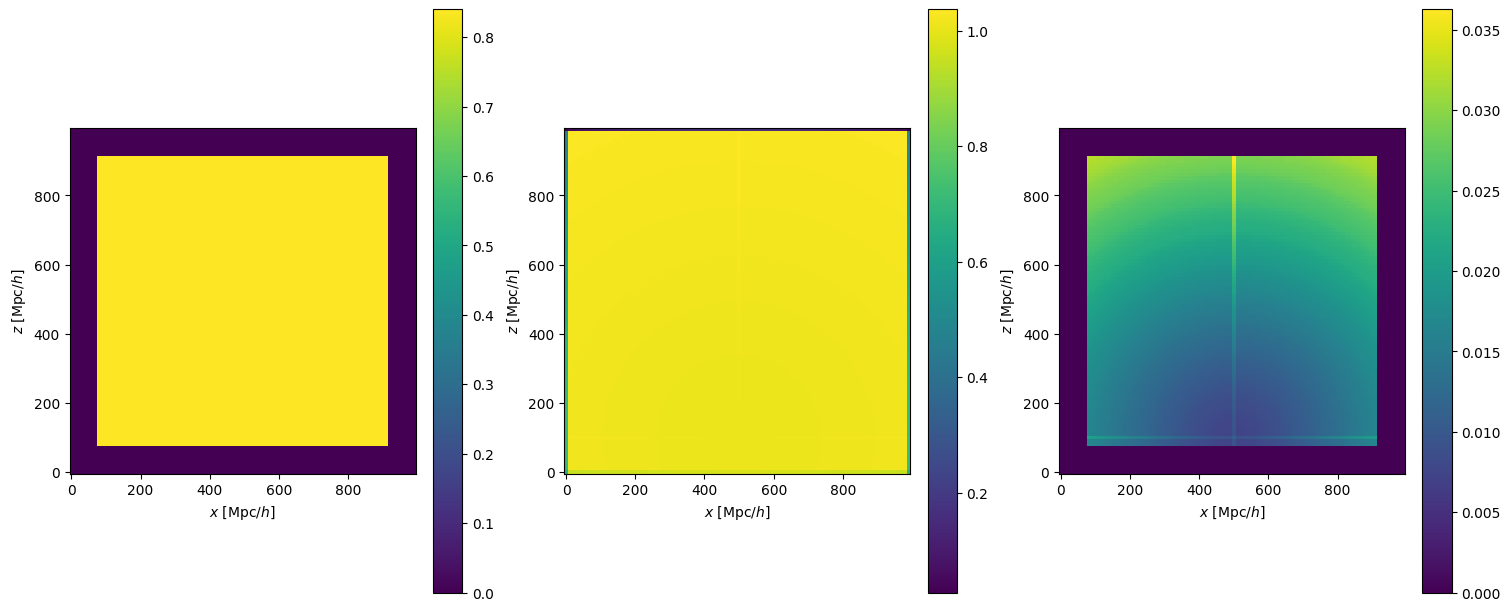

In [184]:
from montecosmo.plot import plot_mesh
ax = -2
plt.figure(figsize=(15, 6), layout='constrained')
plt.subplot(131)
mm0 = masked2mesh(mesh0[rmask], rmask)
plot_mesh(mm0, box_shape, axis=ax)
plt.colorbar()

plt.subplot(132)
mm = masked2mesh(mesh[rmask], rmask)
plot_mesh(mesh, box_shape, axis=ax)
plt.colorbar()

plt.subplot(133)
plot_mesh(mm-mm0, box_shape, axis=ax)
plt.colorbar()

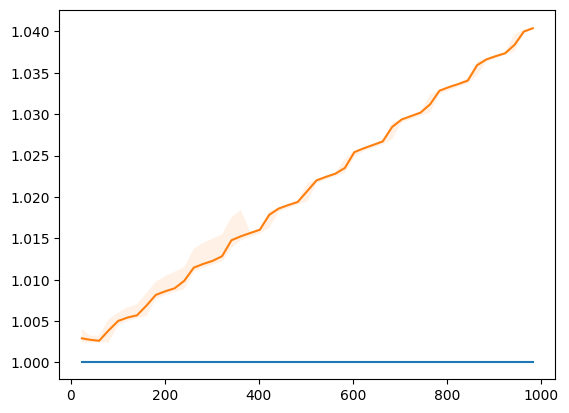

In [185]:
plt.plot(ravg, navg0)
# plt.plot(ravg, nmed0)
plt.fill_between(ravg, *ncredint0.T, alpha=0.1)

plt.plot(ravg, navg)
# plt.plot(ravg, nmed)
plt.fill_between(ravg, *ncredint.T, alpha=0.1)

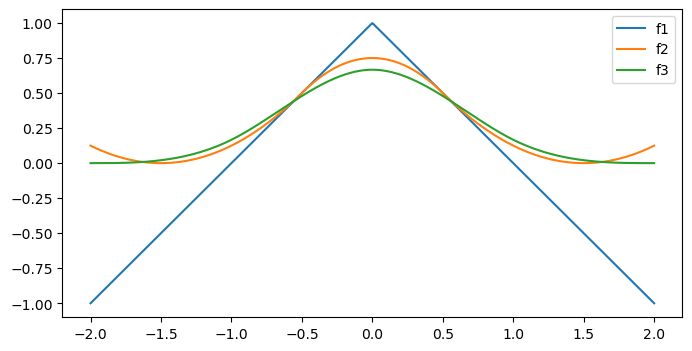

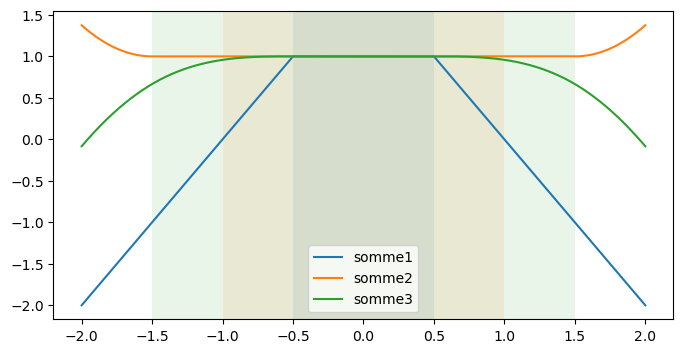

In [ ]:
from montecosmo.nbody import paint_kernels
f1, f2, f3 = lambda x: paint_kernels[2](jnp.abs(x)),  \
            lambda x: paint_kernels[3](jnp.abs(x)), \
            lambda x: paint_kernels[4](jnp.abs(x))
xs = jnp.linspace(-2, 2, 1000)
plt.figure(figsize=(8, 4))
plt.plot(xs, f1(xs), label="f1")
plt.plot(xs, f2(xs), label="f2")
plt.plot(xs, f3(xs), label="f3")
plt.legend()

plt.figure(figsize=(8, 4))
somme1 = lambda xshift: f1(xshift+.5) + f1(xshift-.5)
somme2 = lambda xshift: f2(xshift-1) + f2(xshift + 1) + f2(xshift) 
somme3 = lambda xshift: f3(xshift-1.5) + f3(xshift + 1.5) + f3(xshift+.5) + f3(xshift-.5) 
plt.plot(xs, somme1(xs), label="somme1")
plt.plot(xs, somme2(xs), label="somme2")
plt.plot(xs, somme3(xs), label="somme3")
plt.ylim(plt.ylim())
plt.fill_betweenx(plt.ylim(), -.5, .5, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1, 1, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1.5, 1.5, alpha=.1)
plt.legend()

## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

In [7]:
# overwrite = False
overwrite = True
truth0 = {'Omega_m': 0.3, 
    'sigma8': 0.8,
    'b1': 1.,
    'b2': 0., 
    'bs2': 0., 
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbar': 1e-3,}
cell_budget = 64**3
padding = 0.2
# padding = None
mesh_length = round(cell_budget**(1/3))

if not os.path.exists(save_dir / "truth.npz") or overwrite:
    print("Generate truth...")
    model = FieldLevelModel(**default_config | 
                                {'mesh_shape': 3*(mesh_length,), 
                                'cell_length': 3000 / mesh_length, 
                                'box_center': (0.,0.,2000.), # in Mpc/h
                                'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                                'evolution': 'lpt',
                                'a_obs': .5, # light-cone if None
                                'curved_sky': False, # curved vs. flat sky
                                'ap_auto': False, # parametrized AP vs. auto AP
                                'window': padding, # if float, padded fraction, if str or Path, path to window mesh file
                                'oversampling': 1.,
                                'paint_order': 2,
                                } )
    
    # fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    # # fits_path = Path("/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    # model.add_window(fits_path, cell_budget, padding, save_dir / "window.npy")
    
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)

    # model2 = FieldLevelModel(**model.asdict() | {'evolution': 'kaiser', 'window':None})
    # model2 = FieldLevelModel(**model.asdict() | {'ap_auto': None})
    # model2 = FieldLevelModel(**model.asdict() | {'paint_order': 3})
    # model2 = FieldLevelModel(**model.asdict() | {'oversampling': 1.})
    
    model2 = FieldLevelModel(**model.asdict())
    # model2.latents['Omega_m']['loc_fid'] = 0.3
    # model2.__post_init__()

    # truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    truth2 = model2.predict(samples=truth0 | {'Omega_m': 0.3111}, hide_base=False, hide_samp=False, from_base=True)

    model2.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth2)
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    truth = np.load(save_dir / "truth.npz")

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    truth2 = np.load(save_dir / "truth2.npz")

print(model)
# model.render()
delta_obs = model.count2delta(truth['obs'])

# print(model2)
# model2.render()
# model2.render("bnet.png")
delta_obs2 = model2.count2delta(truth2['obs'])

Generate truth...
# CONFIG
{'a_obs': 0.5,
 'ap_auto': False,
 'box_center': array([   0.,    0., 2000.]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 46.875,
 'curved_sky': False,
 'evolution': 'lpt',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.01},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso': {'group': 'ap',
                           'high': inf,
                           '

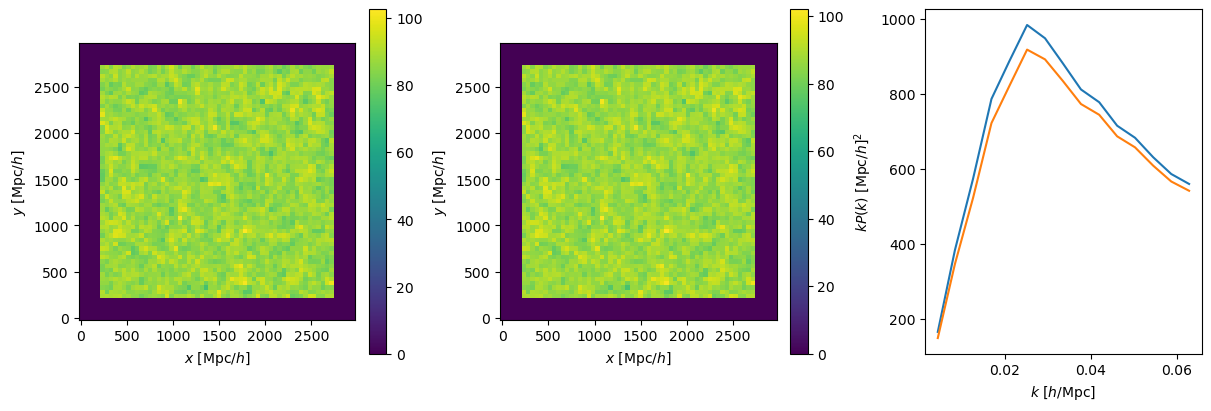

In [8]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 2
ind = 1.
count_obs  = model.masked2mesh(truth['obs'])
count_obs2 = model2.masked2mesh(truth2['obs'])

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(count_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(count_obs2, model2.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)
plot_pow(*kpow);
plot_pow(*kpow2);
# plt.savefig("./figs_png/omega/apauto1_noise00.png", dpi=300, bbox_inches='tight')

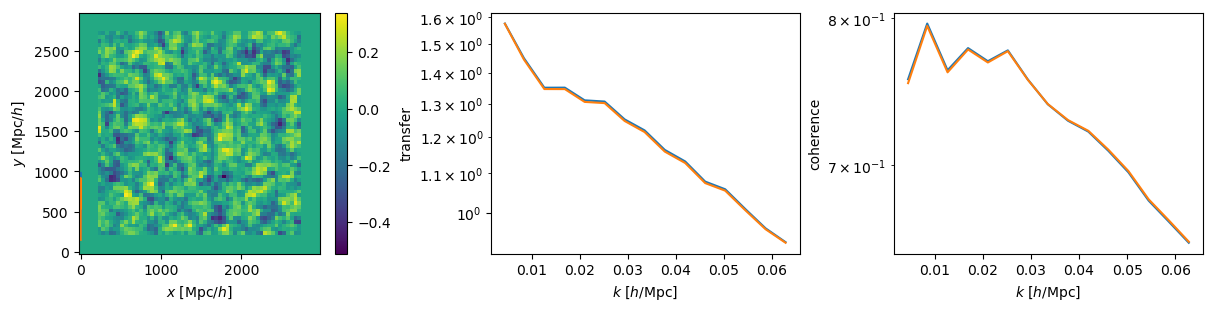

In [9]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kptc = model.powtranscoh(mesh_true, delta_obs)
mesh_true2 = jnp.fft.irfftn(truth2['init_mesh'])
kptc2 = model2.powtranscoh(mesh_true2, delta_obs2)

plt.figure(figsize=(12, 3), layout='constrained')
plot_powtranscoh(*kptc)
plot_powtranscoh(*kptc2)
plt.subplot(131)
ind = 1.
plot_mesh(count_obs2-count_obs, model.box_shape, ind, axis)
plt.colorbar();
# plt.savefig("./figs_png/omega/apauto1_noise_diff00.png", dpi=300, bbox_inches='tight')

In [10]:
count_obs.mean(), count_obs2.mean(),   count_obs.mean() / count_obs2.mean()

(Array(61.85704371, dtype=float64),
 Array(61.85704371, dtype=float64),
 Array(1., dtype=float64))

In [11]:
from montecosmo.bricks import lin_power_mesh, regular_pos, kaiser_model
from montecosmo.nbody import paint, read, deconv_paint, lpt, paint_kernels

model.ptcl_shape = np.array((350, 350, 350))
model.mesh_shape = np.array((350, 350, 350))

mesh = jr.normal(jr.key(0), model.mesh_shape)
pmesh = lin_power_mesh(model.cosmo_fid, model.mesh_shape, model.box_shape)
# mesh = jnp.fft.irfftn(jnp.fft.rfftn(mesh) * pmesh**.5)
mesh = jnp.fft.rfftn(mesh) * pmesh**.5

kaimesh = kaiser_model(model.cosmo_fid, 0.5, 1., mesh)

def unif_pos(mesh_shape, ptcl_shape, seed=42):
    if isinstance(seed, int):
        seed = jr.key(seed)
    pos = jr.uniform(seed, shape=(ptcl_shape.prod(), 3), minval=0, maxval=mesh_shape)
    return pos

def sobol_pos(mesh_shape, ptcl_shape, seed=42):
    from scipy.stats import qmc
    sampler = qmc.Sobol(d=3, scramble=True, seed=seed)
    return jnp.array(sampler.random(n=ptcl_shape.prod()) * mesh_shape)


kai


In [12]:
pos = regular_pos(model.mesh_shape, model.mesh_shape)
regpos = regular_pos(model.mesh_shape, model.ptcl_shape)
upos = unif_pos(model.mesh_shape, model.ptcl_shape)
# upos = perturb_pos(model.mesh_shape, model.ptcl_shape)

# plt.figure(figsize=(10, 8))
# plt.scatter(pos[:,1], pos[:,0], marker='x', s=10, alpha=.1)
# plt.scatter(regpos[:,1], regpos[:,0], marker='+', s=10, alpha=.1)
# plt.scatter(upos[:,1], upos[:,0], marker='+', s=10, alpha=.5)
# plt.gca().set_aspect('equal')

1
0.75
0.6666666666666666


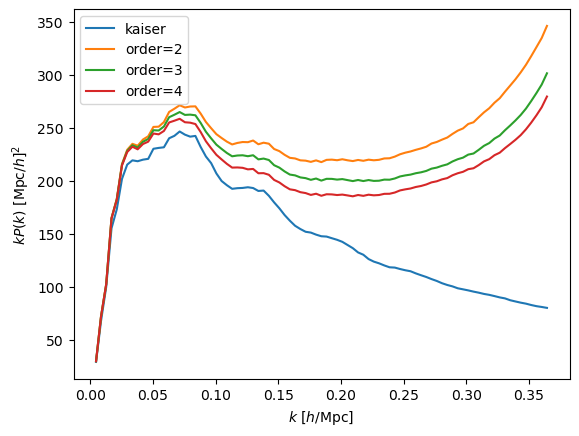

In [18]:
kpow = model.spectrum(kaimesh)
plot_pow(*kpow, label=f"kaiser")

for i in range(2, 5):
    print(paint_kernels[i](0))
    mesh_lpt = mesh
    pos = upos
    # pos = regpos
    # pos = sobpos
    # mesh_lpt = deconv_paint(mesh_lpt, order=i)
    fac = 0.63033668 if i==3 else 0.555599137 if i==4 else 1.
    dpos, vel = lpt(model.cosmo_fid, mesh_lpt, pos, a=0.5, lpt_order=1, paint_order=i)

    delta = paint(pos + dpos, tuple(model.mesh_shape), order=i)
    delta = deconv_paint(delta, order=i)
    kpow = model.spectrum(delta)
    plot_pow(*kpow, label=f"order={i}")
plt.legend();
# plt.savefig("lpt2_readi_regpos_divker0.png", bbox_inches='tight')

In [46]:
fac3 = 0.46700983 / 0.74088950
fac4 = 0.411637567021 / 0.74088950
fac3, fac4, paint_kernels[3](0), paint_kernels[4](0)

(0.6303366831356093, 0.5555991372816055, 0.75, 0.6666666666666666)

In [49]:
fac3 = 0.768149959 / 1.2186344033
fac4 = 0.67707221539 / 1.2186344033
fac3, fac4, paint_kernels[3](0), paint_kernels[4](0)

(0.6303366759709794, 0.5555991309259962, 0.75, 0.6666666666666666)

In [15]:
inmesh = jnp.fft.irfftn(mesh)
# inmesh = kaimesh
for i in range(1, 5):
    vals = read(regpos, inmesh, order=i)
    print(vals.mean(), vals.std())
print(inmesh.mean(), inmesh.std())

-1.2727622648717363e-19 1.2186344033595038
-1.2727622648717363e-19 1.2186344033595038
-1.060635220726447e-19 0.7681499595100806
2.121270441452894e-20 0.6770722153949071
-1.2727622648717363e-19 1.2186344033595038


In [16]:
# inmesh = jnp.fft.irfftn(mesh)
inmesh = kaimesh
for i in range(1, 5):
    vals = read(regpos, inmesh, order=i)
    print(vals.mean(), vals.std())
print(inmesh.mean(), inmesh.std())

1.0 0.7408895085072241
1.0 0.7408895085072241


1.0 0.46700983034152527
1.0 0.411637567021686
1.0 0.7408895085072241


In [ ]:
from montecosmo.nbody import rfftk, a2f
from montecosmo.bricks import tophysical_mesh
from montecosmo.utils import safe_div

init_mesh = truth['init_mesh']
bE = 2.
los, a = tophysical_mesh(model.box_center, model.box_rot, model.box_shape, model.mesh_shape,
                    model.cosmo_fid, model.a_obs, model.curved_sky)

kvec = rfftk(model.mesh_shape)
kmesh = sum(kk**2 for kk in kvec)**.5 # in cell units

mu_delta = jnp.stack([jnp.fft.irfftn(
        safe_div(kvec[i] * init_mesh, kmesh)
        ) for i in range(3)], axis=-1)
mu_delta = (mu_delta * los).sum(-1)
mu_delta = jnp.fft.rfftn(mu_delta)

mu2_delta = jnp.stack([jnp.fft.irfftn(
        safe_div(kvec[i] * mu_delta, kmesh)
        ) for i in range(3)], axis=-1)
mu2_delta = (mu2_delta * los).sum(-1)

delta = (bE * jnp.fft.irfftn(init_mesh) + a2f(model.cosmo_fid, a) * mu2_delta)




from jax.scipy.special import sph_harm
# from jax.scipy.special import sph_harm_y # JAX >= 0.6.1
mu2_delta = jnp.fft.irfftn(init_mesh) / 3
for m in range(-2, 3):
    sph_harm()

## Perform the inference

### Warmup the field only

In [ ]:
n_samples, n_runs, n_chains = 128, 12, 8
tune_mass = True
overwrite = True
# overwrite = False

params_init = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains))    
params_init2 = jit(vmap(partial(model2.kaiser_post, delta_obs=delta_obs2)))(jr.split(jr.key(45), n_chains))

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, from_base=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), {k: params_init[k] for k in ['init_mesh_']})
    pdump(state, save_path+"_warm_state.p")
    pdump(config, save_path+"_warm_conf.p")
else:
    state = pload(save_path+"_warm_state.p")
    config = pload(save_path+"_warm_conf.p")

# obs = ['obs','b1','b2','bs2','bn2','bnp','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','ngbar']
# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar']
# obs = ['obs','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b2','bs2','bn2','bnp','alpha_iso','alpha_ap']
obs = ['obs','fNL','b2','bs2','bn2','bnp','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b2','bs2','bn2','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','alpha_iso','alpha_ap']
# obs = ['obs', 'ngbar']
obs = {k: truth[k] for k in obs}

model.reset()
model.condition(obs, from_base=True)
model.render()
model.block()

params_warm = params_init | state.position
params_warm = {k: params_warm[k] for k in params_warm.keys() - model.data.keys()}

norsd
norsd
norsd
norsd
Warming up...
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd


In [ ]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp

mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_init2 = vmap(lambda x: model2.powtranscoh(mesh_true, model2.reparam(x, fourier=False)['init_mesh']))(params_init2)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)

norsd
norsd
norsd


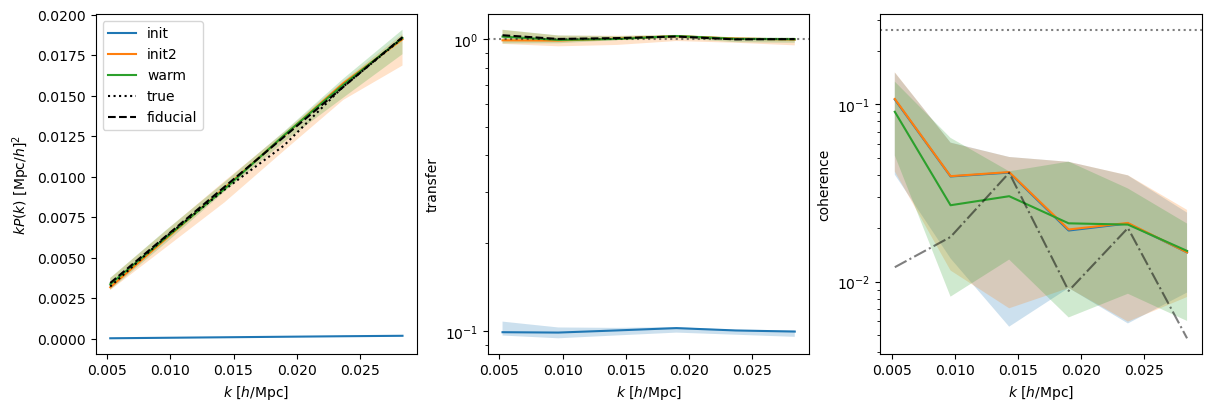

In [ ]:
prob = 0.95

plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_init2, label='init2')
plot_kptcs(kptcs_warm, label='warm')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k-.', alpha=0.5, label='obs');
plt.axhline(model.wind_mesh.mean(), linestyle=':', color='k', alpha=0.5)
plt.savefig(save_path+f'_init_warm.png')   

### Warmup all parameters and run

In [ ]:
# jconfig.update("jax_debug_nans", True)
from tqdm import tqdm
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
overwrite = True
# overwrite = False

params_warm['init_mesh_']  = jnp.broadcast_to(truth['init_mesh_'], jnp.shape(params_warm['init_mesh_']))

if not os.path.exists(save_path+"_warm2_state.p") or overwrite:
    print("Warming up...")
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, # 2**13
                                        # desired_energy_var=2e-7, diagonal_preconditioning=tune_mass)))
                                        desired_energy_var=2e-8, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_warm)

    print("ss: ", config.step_size)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)
    
    pdump(state, save_path+"_warm2_state.p")
    pdump(config, save_path+"_conf.p")
    start = 1

    print("ss: ", config.step_size[0])
    print("L: ", config.L[0])
    from jax.flatten_util import ravel_pytree
    flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
    print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))
    print(tree.map(vmap(lambda x: jnp.isnan(x).sum()), state.position))
    

elif not os.path.exists(save_path+"_last_state.p") or overwrite:
    state = pload(save_path+"_warm2_state.p")
    config = pload(save_path+"_conf.p")
    start = 1

else:
    state = pload(save_path+"_last_state.p")
    config = pload(save_path+"_conf.p")
    start = 100 ###########


print("Running...")
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=64, progress_bar=False)))
seed = jr.key(42)

end = start + n_runs - 1
for i_run in tqdm(range(start, end + 1)):
    print(f"run {i_run}/{end}")
    seed, run_seed = jr.split(seed, 2)
    state, samples = run_fn(jr.split(run_seed, n_chains), state, config)
    
    print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+"_last_state.p")



Warming up...
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd


In [ ]:
!scancel 5637141

In [ ]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))